# Data visualization
This notebook shows all the steps and codes to produce the graphics and visual analyzes we have done. In particular, we start with a description of the frequencies of the various classes, and then move on to the locations and embeddings.

## Table of contents
1. [Class frequencies](#frequencies) <br>
    1.1 [Super categories distribution](#super) <br>
    1.2 [Aves categories distribution](#aves) <br>
3. [Images and boxes examples](#examples) <br>
4. [Locations](#locations) <br>
5. [Images embeddings](#embeddings) <br>

In [1]:
# importing libraries
import requests
import torch.nn.functional as F
from transformers import (
    VisionTextDualEncoderModel,
    AutoFeatureExtractor,
    AutoTokenizer
)
from glob import glob
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from transformers import CLIPModel, CLIPProcessor


import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from torchvision import transforms
from PIL import Image
import pandas as pd
import json
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
#from bs4 import BeautifulSoup
import numpy as np
from PIL import Image
import torchvision
import torch
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time
from tqdm.notebook import tqdm
import random
import pickle
import shutil

## 1. Class frequencies <a class="anchor" id="frequencies"></a>

In this section we explore the frequency distributions of the images, to check for possible imbalances

### 1.1 Super categories distribution <a class="anchor" id="super"></a>

The [iNaturalis](https://github.com/visipedia/inat_comp/tree/master/2017) dataset provides the following super categories (note that we will not use the same train - val split, as explained in the ```data_processing.ipynb``` notebook. 

| Super Category |	Category Count	| Train Images |	Val Images |
|------|---------------|-------------|---------------|
|Plantae|2,101|158,407|38,206|
|Insecta|1,021|100,479|18,076|
|Aves|964|214,295|21,226|
|Reptilia|289|35,201|5,680|
|Mammalia|186|29,333|3,490|
|Fungi|121|5,826|1,780|
|Amphibia|115|15,318|2,385|
|Mollusca|93|7,536|1,841|
|Animalia|77|5,228|1,362|
|Arachnida|56|4,873|1,086|
|Actinopterygii|53|1,982|637|
|Chromista|9|398|144|
|Protozoa|4|308|73|
|||||
|Total|5,089|579,184|95,986|


Instead, if we focus only on the distribution of the box frequencies, we have the following frequencies:

| Super Category | Train Boxes |	Val Boxes |
|------|---------------|-------------|
|Insecta|106,304|16,732|
|Aves|283,931|17,314|
|Reptilia|36,476|5,480|
|Mammalia|31,109|2,654|
|Amphibia|15,812|2,280|
|Mollusca|8,566|1,571|
|Animalia|6,643|1,143|
|Arachnida|4,752|1,051|
|Actinopterygii|2,571|511|
|||||
|Total|496,164|48,736|


It is evident that not all the super categories have the box annotations available. We then proceeded to remove those super categories and we produce a bar plot to visualize the frequencies.

In [2]:
from SATM.preprocess import merge_aves_df
# merging train and val dataset to perform a train val test split
#df = pd.concat([json2df("train_2017_bboxes.json"), json2df("val_2017_bboxes.json")])
df = merge_aves_df("train_2017_bboxes.json", "val_2017_bboxes.json")
df.head()

,license,file_name,rights_holder,height,width,id,area,iscrowd,image_id,bbox,category_id,id_y,identifier,category_name,super_category_name
139706,3,train_val_images/Aves/Bubulcus ibis/26a9157b48...,greglasley,545,800,213252,37238.0,0,213252,"[230, 199, 433, 172]",2912,153173,26a9157b48f66f71032f75ac70a11db7.jpg,Bubulcus ibis,Aves
214110,3,train_val_images/Insecta/Feltia herilis/8e7ecc...,leplady0209,600,800,318689,53133.5,0,318689,"[194, 138, 323, 329]",4169,235593,8e7ecc6f1bf06ad53acb8326b8696740.jpg,Feltia herilis,Insecta
429742,3,train_val_images/Aves/Tringa solitaria/a766afd...,J. Maughn,591,800,598727,6950.0,0,598727,"[113, 274, 139, 100]",3890,468382,a766afd4faa3b87cece8760ebaa6d9d1.jpg,Tringa solitaria,Aves
191185,3,train_val_images/Insecta/Manduca sexta/4f86fdb...,hobiecat,732,800,284974,194892.0,0,284974,"[146, 56, 654, 596]",3771,210301,4f86fdb62ca07b7257a1ab9a72816d98.jpg,Manduca sexta,Insecta
458018,3,train_val_images/Aves/Haemorhous mexicanus/e28...,cuskelly,600,800,631689,22000.0,0,631689,"[269, 129, 125, 352]",4506,498071,e28ff6dc89c379783c08bba85f66371c.jpg,Haemorhous mexicanus,Aves


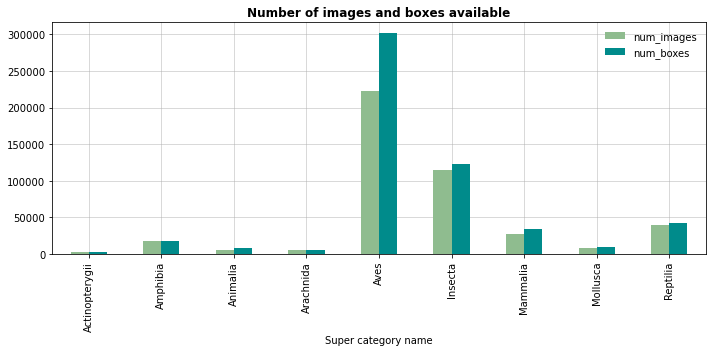

In [3]:
# super category distribution
pd.DataFrame({"num_images" : df.drop_duplicates("image_id").groupby("super_category_name").size(),
              "num_boxes" : df.groupby("super_category_name").size()}).plot.bar(figsize = (10,5),
                                                                                zorder = 10,
                                                                                color = ["darkseagreen", "darkcyan"])

plt.title("Number of images and boxes available", fontsize = 12, weight = "bold")
plt.legend(fancybox=True, framealpha=0)
plt.grid(zorder = -10, alpha = 0.6)
plt.xlabel("Super category name")
plt.tight_layout()
plt.savefig("plots/super_categories.pdf", bbox_inches='tight', transparent = True)

**Aves** (birds) is by far the most populated super category. We have therefore decided to focus exclusively on birds, which allow us to have a sufficiently large number of images, suitable for training models.\
Aves super category provides 964 sub-categories. The idea of our project is to do **object detection**, recognizing the category of birds. Working with 964 categories is prohibitive, not only due to their high number, but also because some of these sub-categories have very few images, so training would be difficult.

### 1.2 Aves categories distribution <a class="anchor" id="aves"></a>

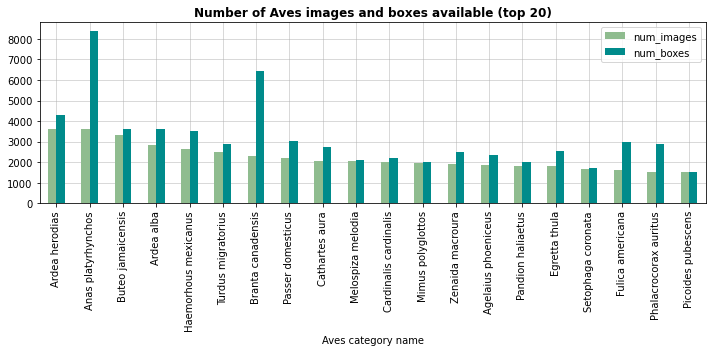

In [4]:
pd.DataFrame({"num_images": df[df.super_category_name == "Aves"].drop_duplicates("image_id").groupby("category_name").size().sort_values(ascending = False).head(20), 
             "num_boxes": df[df.super_category_name == "Aves"].groupby("category_name").size()}).dropna().sort_values("num_images", ascending = False).plot.bar(figsize = (10,5),
                                                                                zorder = 10,
                                                                                color = ["darkseagreen", "darkcyan"])
plt.title("Number of Aves images and boxes available (top 20)", fontsize = 12, weight = "bold")
plt.grid(zorder = -10, alpha = 0.6)
plt.xlabel("Aves category name")
plt.tight_layout()
plt.savefig("plots/20aves.pdf", bbox_inches='tight', transparent = True)

In the barplot above, the number of images and boxes of the top 20 most populated aves subcategories are displayed. The frequencies are computed from the .json files. We want to focus only on the top 10 subcategories.\
Browsing the dowloaded images, the frequencies of the subcategories are not exactly the same as the one plotted above, probably because some images are missing or corrupted while uploading or downloading from OneDrive.\
The bar plot below shows the frequencies of the top 10 aves categories considering the images we were able to download. We will focus on those.

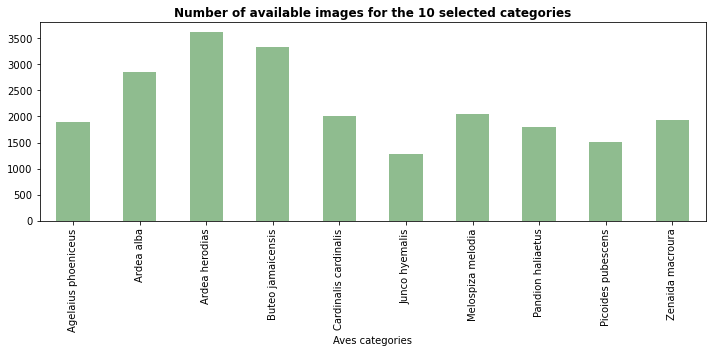

In [5]:
# from the downloaded images

pd.DataFrame({cat:len(os.listdir("Aves"+"/"+cat)) for cat in os.listdir("Aves")},
             index = ["num_images"]).T.sort_index().plot.bar(color = "darkseagreen", figsize = (10, 5), zorder = 10, legend = False)
plt.title("Number of available images for the 10 selected categories", weight = "bold")
#plt.grid(zorder = -10, alpha = 0.7)
plt.xlabel("Aves categories")
plt.legend
plt.tight_layout()
plt.savefig("plots/selected_aves.pdf", bbox_inches='tight', transparent = True)

In [6]:
# retrieving the list of categories
category_list = os.listdir("Aves") # going through the directories in the Aves folder.
pd.DataFrame(category_list, columns = ["Category"])

,Category
0,Melospiza melodia
1,Ardea alba
2,Pandion haliaetus
3,Cardinalis cardinalis
4,Zenaida macroura
5,Agelaius phoeniceus
6,Junco hyemalis
7,Ardea herodias
8,Buteo jamaicensis
9,Picoides pubescens


Each image has a unique id, and the .jpg files are named with the id, in the following way: _```unique_id.jpg```_ as in the example below

In [7]:
#from SATM.preprocess import clean_aves
img_list = [i for cat in category_list for i in os.listdir("Aves/"+cat)]
print("Example of element in the list:",img_list[0])

Example of element in the list: 959d8aadbbcd72f1938bb162cc7dd10e.jpg


In [8]:
print("Number of available aves images:", len(img_list))

Number of available aves images: 22257


In [10]:
# removing from the dataframe all the pictures for which we haven't downloaded the corresponding file
# ie, images not belonging to the Aves category
df = df[df.identifier.isin(img_list)]
print("Number of available aves boxes:", len(df))

Number of available aves boxes: 25636


We have 22257 images, distributed across 10 aves categories. The boxes are 25636, this means that we have images featuring more than box. The rate of boxes per images is in fact approximatively equal to 1.15\
The barplot below shows the number of images and boxes per each aves subcategory. 

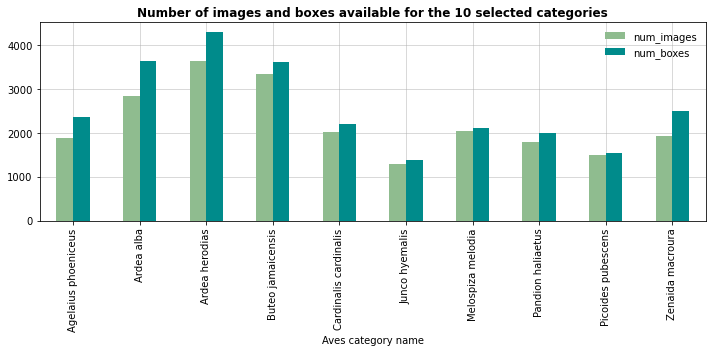

In [11]:
pd.DataFrame({"num_images" : df.drop_duplicates("image_id").groupby("category_name").size(),
              "num_boxes" : df.groupby("category_name").size()}).plot.bar(figsize = (10,5),
                                                                                zorder = 10,
                                                                                color = ["darkseagreen", "darkcyan"])

plt.title("Number of images and boxes available for the 10 selected categories", fontsize = 12, weight = "bold")
plt.grid(zorder = -10, alpha = 0.6)
plt.xlabel("Aves category name")
plt.legend(fancybox=True, framealpha=0)
plt.tight_layout()
plt.savefig("plots/selected_aves_bbox.pdf", bbox_inches='tight', transparent = True)

From the barplot we see that the most populated category is the **Ardea herodias**, followed by **Buteo jamaicensis** and **Ardea alba**, while the least populated is the **Junco hyemalis**.

In [12]:
pd.DataFrame({"num_images" : df.drop_duplicates("image_id").groupby("category_name").size(),
              "num_boxes" : df.groupby("category_name").size()}).sort_values("num_images", ascending = False)

,num_images,num_boxes
category_name,,
Ardea herodias,3627,4299
Buteo jamaicensis,3328,3612
Ardea alba,2848,3640
Melospiza melodia,2050,2098
Cardinalis cardinalis,2006,2207
Zenaida macroura,1932,2502
Agelaius phoeniceus,1888,2348
Pandion haliaetus,1794,1999
Picoides pubescens,1503,1546


In [13]:
from SATM.preprocess import encode_df
# adding the encoded category to the dataframe.
df = encode_df(df)

## 2. Images and boxes examples <a class="anchor" id="examples"></a>

To visualize the type of data we have, in this section we plot example images of the birds, with their bounding boxes, as provided by iNaturalist.

In [14]:
# importing function and classes to load sample images
from SATM.preprocess import generate_box, generate_target, plot_image_from_output, AvesDataset

In [15]:
# list of colors
colors = ["red", "orange", "gold", "lawngreen", "green", "steelblue", "blue", "darkviolet", "magenta", "pink"]

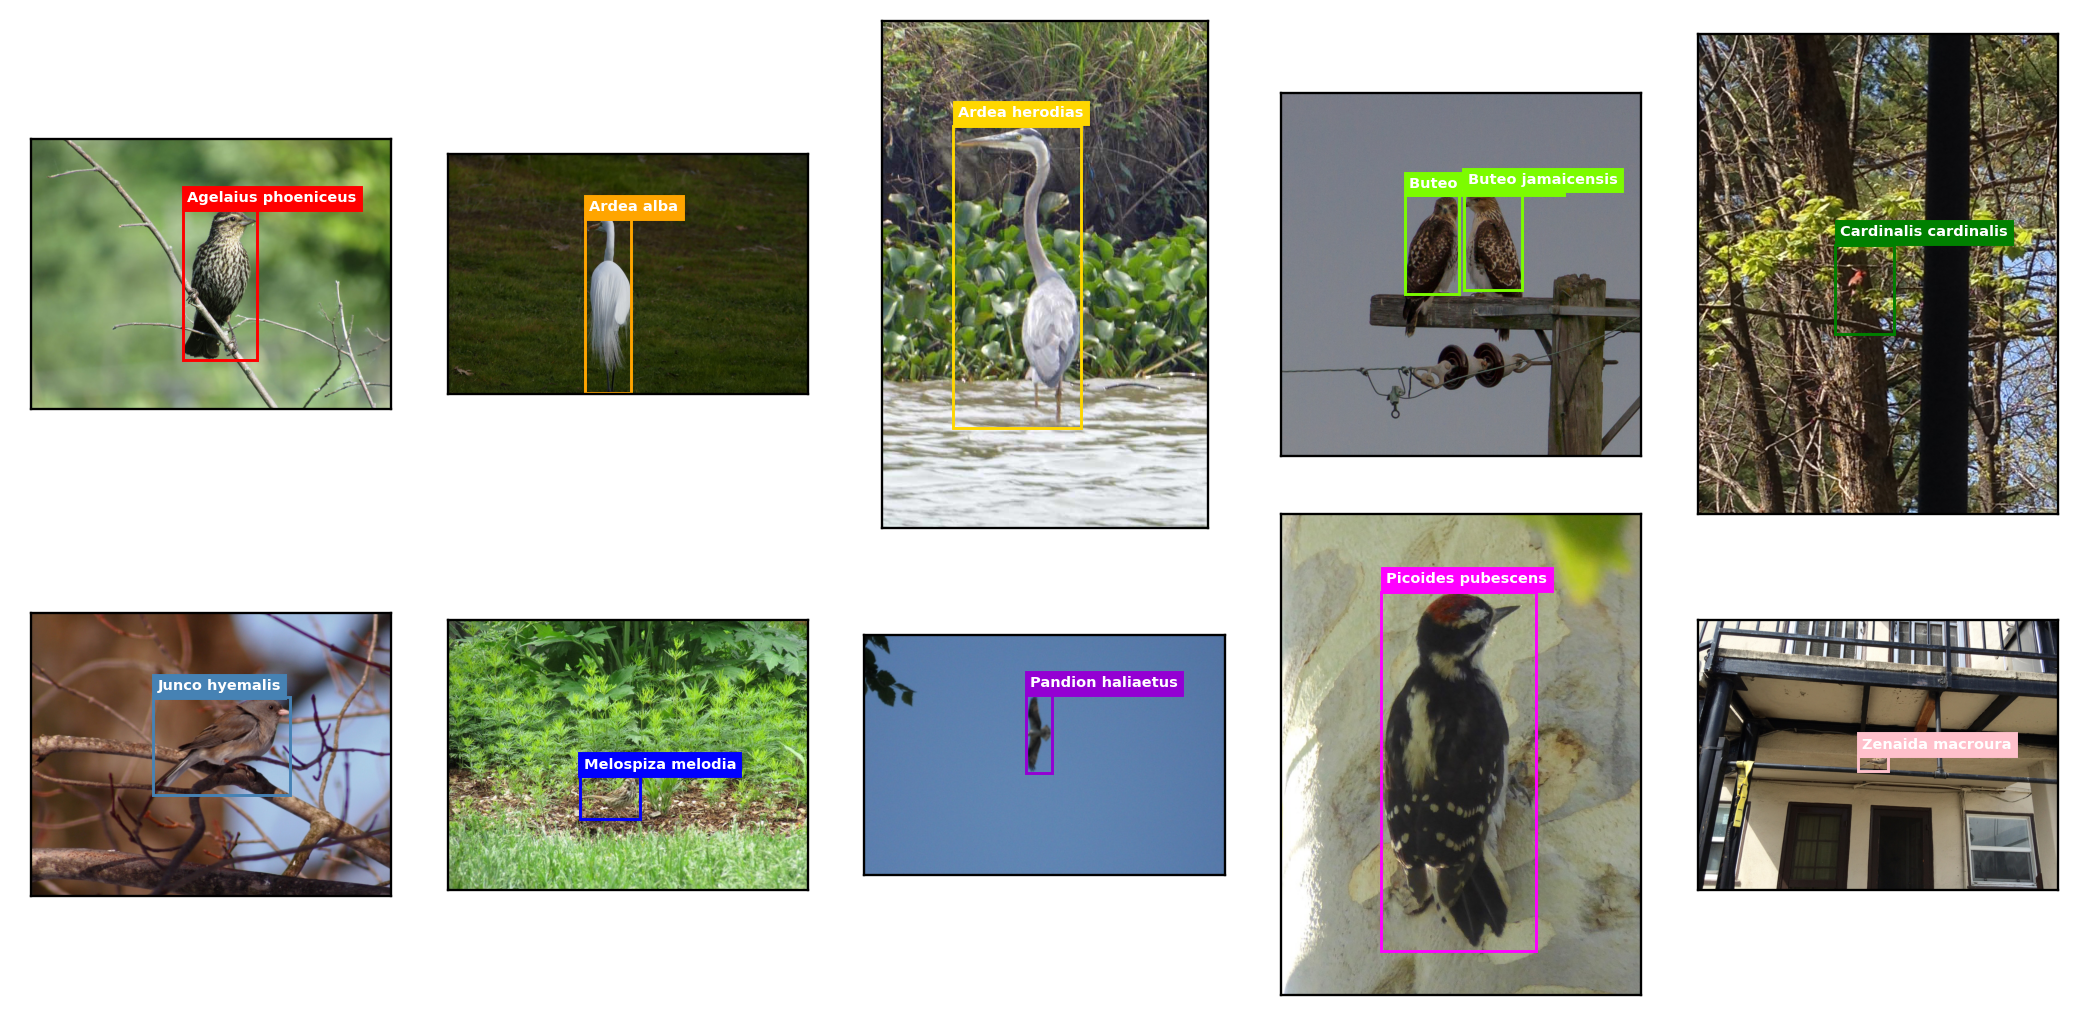

In [16]:
data_transform = transforms.Compose([  # transforms.Compose : a class that calls the functions in a list consecutively
        transforms.ToTensor() # ToTensor : convert numpy image to torch.Tensor type
    ])
fig,ax = plt.subplots(2,5, figsize = (10,5), dpi = 210)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.00001)

axes = ax.flatten()
np.random.seed(22) # setting a random seed for reproducibility 
for i,cat in enumerate(sorted(category_list)): # iterating across the categories
    
    temp = AvesDataset(data_transform, f'Aves/{cat}', df) # loading pictures belonging to the category
    which = np.random.randint(1,len(temp)) # randomly sampling one image
    img = temp[which][0]
    annotation = temp[which][1]
    img = img.cpu().permute(1,2,0)
    
    axes[i].imshow(img)
    #axes[i].set_title(cat, fontsize = 10, weight = "bold", color = colors[i])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    for idx in range(len(annotation["boxes"])):
        
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor=colors[i],facecolor="none")

        axes[i].add_patch(rect)
        props = dict(boxstyle='square', edgecolor=colors[i], facecolor=colors[i], alpha=1)
        axes[i].text(xmin+9, ymin-9, cat, verticalalignment='bottom', horizontalalignment = "left", fontsize=5, bbox=props, color = "white", weight = "bold")
plt.tight_layout()
plt.savefig("plots/pictures_example.pdf", bbox_inches='tight', transparent = True)

In the panel above, we display a sample picture per each category. In the dataset we have, no image features two birds belonging to different categories.

## 3. Locations <a class="anchor" id="locations"></a>

In the _.json files_, we also have information concerning the exact location where each photo was taken. As a further data exploration goal, we plot these locations, using the ```geopandas``` library

In [19]:
# opening dataframes
with open('pickles/train.pickle', 'rb') as handle:
    train_df = pickle.load(handle)
with open('pickles/val.pickle', 'rb') as handle:
    val_df = pickle.load(handle)
with open('pickles/test.pickle', 'rb') as handle:
    test_df = pickle.load(handle)

In [17]:
# importing locations (stored in json files)

# Python program to read
# json file
# Opening JSON file
f1 = open("train2017_locations.json")
f2 = open("val2017_locations.json")
# returns JSON object as 
# a dictionary
df1 = json.load(f1)
df2 = json.load(f2)


# Iterating through the json
# list
#for i in data['emp_details']:
    #print(i)
f1.close()
f2.close
locations = pd.concat([pd.DataFrame(df1), pd.DataFrame(df2)])

In [18]:
locations.head() # locations of the entire iNaturalist dataset, we need to extract aves-only images

,loc_uncert,date,valid,user_id,lat,date_c,lon,id
0,5.0,2016-07-09,True,108450.0,36.448268,0.5192,-118.595215,1
1,5.0,2016-07-09,True,108450.0,36.448268,0.5192,-118.595215,2
2,5.0,2016-07-09,True,108450.0,36.448268,0.5192,-118.595215,3
3,8034.0,2006-07-03,True,304765.0,37.004952,0.5027,-106.345499,4
4,8034.0,2006-07-03,True,304765.0,37.004952,0.5027,-106.345499,5


In [19]:
# merging the previous dataframe with the aves dataframes, using image id as key
aves_locations = pd.merge(locations,
        pd.concat([train_df, val_df, test_df]),
        left_on = "id", right_on = "image_id")[["lat", "lon", "image_id", "category_id", "category_name"]]
aves_locations.drop_duplicates("image_id", inplace = True)
aves_locations.head()
# the dataframe is now ready to be plotted

,lat,lon,image_id,category_id,category_name
0,41.820214,-88.046344,2199,8,Picoides pubescens
1,49.185729,-123.976081,2200,8,Picoides pubescens
2,38.184844,-107.774135,2201,8,Picoides pubescens
3,38.184844,-107.774135,2202,8,Picoides pubescens
4,33.014058,-117.252914,2204,8,Picoides pubescens


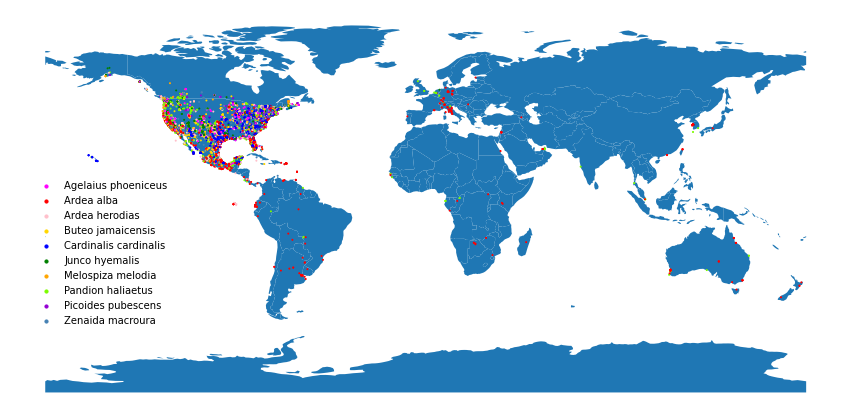

In [20]:
#pip install geopandas
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

#df = pd.read_csv("Long_Lats.csv", delimiter=',', skiprows=0, low_memory=False)


geometry = [Point(xy) for xy in zip(aves_locations['lon'], aves_locations['lat'])]
gdf = GeoDataFrame(aves_locations, geometry=geometry)
c = [colors[i-1] for i in aves_locations.category_id]
labels = list(aves_locations.category_name)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
obj = gdf.plot(ax=world.plot(figsize=(15, 10)), marker='o', color=c, markersize=1)
plt.axis('off')

tdf = aves_locations.drop_duplicates("category_name")[["category_id", "category_name"]].sort_values("category_name").reset_index(drop = True)
for i in range(len(tdf)):
    plt.scatter(10,10, color = colors[tdf.category_id[i]-1], label = tdf.category_name[i], s = 10, zorder = -10)
plt.legend(loc = (0.03,0.2), frameon=False)

plt.savefig("plots/map.pdf", transparent = True)
plt.show()

Pictures are mainly concentrated in USA, except for **Ardea alba** and **Pandion haliaetus** that are also present in the other continents.

## 4. Images embeddings <a class="anchor" id="embeddings"></a>

To investigate if there is the possibility of classification and object detection, before using the models, we want to see if the photo embeddings, once plotted in a 2D graph, are distinguishable according to the category they belong to. To perform the embedding we use [CLIP](https://openai.com/blog/clip/), a pre trained model that is able to embed images and texts. In our project we use CLIP just on images data. Each image is embedded into a 512 vector.\
To visulize these 512 dimensional vectors, we use PCA to reduce the dimension to 2, allowing us to plot them in a 2D scatter plot.\
Since the train dataset is very large, we will work on the Val set, for time reasons (note the Val set, as it was constructed, is likley to be very representative of the training set)

In [4]:
#pip install transformers

In [5]:
# importing needed libraries
from SATM.preprocess import (plot_images, scatter_with_pca,
                            get_image_from_url, embed_texts, embed_images,
                            legend_without_duplicate_labels, scatter_pca)

In [6]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [7]:
images = [get_image_from_url("data/images/Val/"+i) for i in tqdm(os.listdir("data/images/Val/"))]
c_scatter = [colors[val_df[val_df.identifier == i].category_id.iloc[0]-1] for i in tqdm(os.listdir("data/images/Val/"))]
cat_scatter = [val_df[val_df.identifier == i].category_name.iloc[0] for i in tqdm(os.listdir("data/images/Val/"))]

  0%|          | 0/2224 [00:00<?, ?it/s]

  0%|          | 0/2224 [00:00<?, ?it/s]

  0%|          | 0/2224 [00:00<?, ?it/s]

In [17]:
# !! takes a lot to run !! 
image_embed = embed_images(images, processor, model)
# saving embedded images
with open('pickles/embeddings.pickle', 'wb') as handle:
    pickle.dump(image_embed, handle)

In [8]:
with open('pickles/embeddings.pickle', 'rb') as handle:
    image_embed = pickle.load(handle)

  0%|          | 0/2224 [00:00<?, ?it/s]

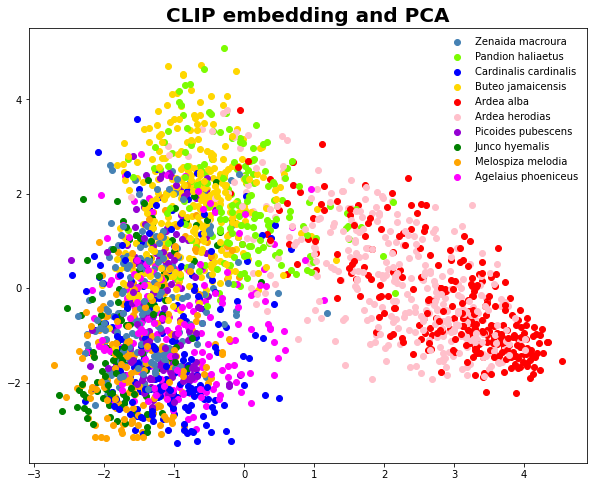

In [9]:
scatter_pca(image_embed, c_scatter, cat_scatter)

From the scatter plot above, it is not immediate to distinguish the various categories in space. This is straightforward, since we are reducing the allowed dimensions to 2, possibily losing relevant information. An interesting result that can be deduced, however, is that Ardea alba (red) and Ardea herodias (pink), which belong to the same species and are visually very similar to each other, are overlying in the bidimensional embdedding space.